## Spend Categorization - Data Exploration
This notebook does some basic EDA for spend categorization, but mainly gets the data ready for the data science to follow. The spend data (category_tree and order) were manually uploaded, but this would be done with a synced ingestion job with Lakeflow Connect to SAP

In [1]:
import pandas as pd
from utils import get_spark
spark = get_spark()

In [2]:
df = spark.sql("SELECT * FROM shm.spend.transactions_enh").toPandas()
df['date'] = pd.to_datetime(df['date'])

In [3]:
df.head(5)

,date,order_id,category_level_1,category_level_2,category_level_3,cost_centre,plant,plant_id,region,amount,unit_price,total,supplier,supplier_country,description
0,2024-04-14,ORD-2024-06913-AC,Indirect,Events & Conferences,Conference registration,CC-500-Sales,Vietnam Plant,PLANT-VN,Asia,30,2529.25,75877.50,EventsAsia Ltd,VN,Annual sales conference registration fee for A...
1,2024-01-28,ORD-2024-07360-PV,Direct,Fasteners,Locknut,CC-100-Production,US-West Plant,PLANT-US-W,North America,1,3795.24,3795.24,Fastenal Company,US,Industrial-grade locknuts for production assembly
2,2024-06-12,ORD-2024-03528-YI,Indirect,Marketing & Advertising,Digital ad spend,CC-500-Sales,US-West Plant,PLANT-US-W,North America,12,1902.74,22832.88,MediaVest USA,US,Digital advertising campaign for social media ...
3,2025-01-02,ORD-2025-07528-NZ,Indirect,Temporary Labor / Contracting,Site labor hire,CC-200-Maintenance,Brazil Plant,PLANT-BR,South America,49,398.61,19531.89,Grupo GPS,BR,Temporary site maintenance workers for Brazil ...
4,2024-10-27,ORD-2024-01140-BF,Indirect,Telecom & Connectivity,VOIP subscription,CC-400-IT,US-West Plant,PLANT-US-W,North America,38,4926.18,187194.84,RingCentral,US,Monthly VOIP subscription service for US-West ...


We can see how categorization can quickly spiral out of control. On this small example, we have three level one categories, between 4 to 18 level two categories, and 102 unique level three categories. This is a trivial example and usually there are far more categories that can be difficult to navigate.

In [4]:
df.groupby('category_level_1')['category_level_2'].nunique()

category_level_1
Direct             10
Indirect           18
Non-Procureable     4
Name: category_level_2, dtype: int64

In [5]:
df.groupby('category_level_2')['category_level_3'].nunique()

category_level_2
Bearings & Seals                         3
Blades & Hub Parts                       3
Castings & Forgings                      3
Cleaning & Janitorial                    3
Components                               4
Electrical Assemblies                    3
Events & Conferences                     3
Facilities & Utilities                   4
Fasteners                                3
Finance Charges                          3
Government Services & Taxes              3
Hydraulic Systems                        3
IT & Software                            4
Logistics & Freight                      4
MRO (Maintenance, Repair, Operations)    4
Marketing & Advertising                  3
Miscellaneous Expenses                   2
Office Supplies                          4
Packaging Materials                      3
Payroll                                  3
Professional Services                    5
Raw Materials                            4
Recruitment Services                 

/var/folders/2x/pf13chqx4614qjlmjdgmndv00000gp/T/ipykernel_78426/1890691886.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_spend = df.resample('M', on='date').total.sum()


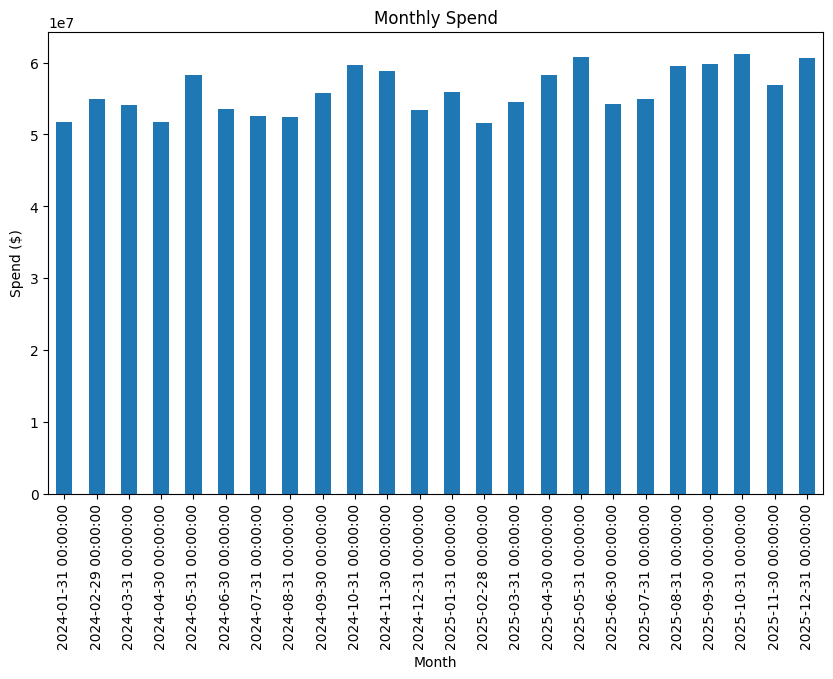

In [6]:
# spend over time 
import matplotlib.pyplot as plt
import pandas as pd

monthly_spend = df.resample('M', on='date').total.sum()

plt.figure(figsize=(10, 6))
monthly_spend.plot(kind='bar')
plt.title('Monthly Spend')
plt.xlabel('Month')
plt.ylabel('Spend ($)')
plt.show()

We are going to take a 500 row sample of our dataframe for consistent experimentation and profiling. But first we are going to make a combined order text field (for inference and vector search) with an index

In [7]:
df.iloc[0]

date                                              2024-04-14 00:00:00
order_id                                            ORD-2024-06913-AC
category_level_1                                             Indirect
category_level_2                                 Events & Conferences
category_level_3                              Conference registration
cost_centre                                              CC-500-Sales
plant                                                   Vietnam Plant
plant_id                                                     PLANT-VN
region                                                           Asia
amount                                                             30
unit_price                                                    2529.25
total                                                         75877.5
supplier                                               EventsAsia Ltd
supplier_country                                                   VN
description         

In [0]:
%sql
SELECT * FROM shm.spend.transactions_gen

In [0]:
%sql
SELECT 
  CONCAT_WS('\n', 
    supplier, supplier_country, order_id, description
  ) AS combined
FROM shm.spend.transactions_enh 
LIMIT 10

In [0]:
%sql
CREATE OR REPLACE TABLE shm.spend.combined AS
SELECT 
  monotonically_increasing_id() as id,
  CONCAT(
    :prompt, '\n',
    'date: ', date, '\n',
    'order_id: ', order_id, '\n',
    'category_level_1: ', category_level_1, '\n',
    'category_level_2: ', category_level_2, '\n',
    'category_level_3: ', category_level_3, '\n',
    'cost_centre: ', cost_centre, '\n',
    'plant: ', plant, '\n',
    'plant_id: ', plant_id, '\n',
    'region: ', region,
    'supplier: ', supplier, '\n',
    'supplier_country: ', supplier_country, '\n',
    'description: ', description, '\n'
  ) AS combined
FROM shm.spend.transactions_enh

Let's take 500 random rows for our test set and persist it

In [0]:
%sql
CREATE OR REPLACE TABLE shm.spend.test AS
SELECT * 
FROM shm.spend.combined
ORDER BY RAND()
LIMIT 500

Now we will make our train dataset - this will be used for both vector search and traditional ML. We also randomize to make it a bit more realistic

In [0]:
%sql
CREATE OR REPLACE TABLE shm.spend.train AS
SELECT * FROM shm.spend.combined
WHERE id NOT IN (SELECT id FROM shm.spend.test)